In [1]:
! pip install -q jupyternotify

In [2]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [3]:
#Importing packages like os, pytorch for working on the Image Classification tasks

import os
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from math import sqrt
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as NN
import torch.optim as optim
import torchvision.models as models
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, r2_score, mean_squared_error

warnings.filterwarnings("ignore")

In [4]:
# Checking if the data exists in a certain place in the local folder or not

os.listdir('archive-license_plates/new_plates/train')

['ALABAMA',
 'ALASKA',
 'AMERICAN SAMOA',
 'ARIZONA',
 'ARKANSAS',
 'CALIFORNIA',
 'CNMI',
 'COLORADO',
 'CONNECTICUT',
 'DELAWARE',
 'FLORIDA',
 'GEORGIA',
 'GUAM',
 'HAWAI',
 'IDAHO',
 'ILLINOIS',
 'INDIANA',
 'IOWA',
 'KANSAS',
 'KENTUCKY',
 'LOUISIANA',
 'MAINE',
 'MARYLAND',
 'MASSACHUSETTS',
 'MICHIGAN',
 'MINNESOTA',
 'MISSIPPI',
 'MISSOURI',
 'MONTANA',
 'NEBRASKA',
 'NEVADA',
 'NEW HAMPSHIRE',
 'NEW JERSEY',
 'NEW MEXICO',
 'NEW YORK',
 'NORTH CAROLINA',
 'NORTH DAKOTA',
 'OHIO',
 'OKLAHOMA',
 'OREGON',
 'PENNSYLVANIA',
 'PUERTO RICO',
 'RHODE ISLAND',
 'SOUTH CAROLINA',
 'SOUTH DAKOTA',
 'TENNESSEE',
 'TEXAS',
 'U S VIRGIN ISLANDS',
 'UTAH',
 'VERMONT',
 'VIRGINIA',
 'WASHINGTON',
 'WASHINGTON DC',
 'WEST VIRGINIA',
 'WISCONSIN',
 'WYOMING']

In [5]:
# Reading the training, testing and validation data for further operations

trainDataPath = 'archive-license_plates/new_plates/train'
testDataPath = 'archive-license_plates/new_plates/test'

In [6]:
# Defining a transformer for each image here for resizing all the data so as to make sure that all the images are of the same size, an converting the images to the tensors

trainTransformer = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
trainData = torchvision.datasets.ImageFolder(root = trainDataPath, transform = trainTransformer)

In [7]:
# Defining a data loader to laod the data from the certain path and go ahead with next steps

trainLoadert = torch.utils.data.DataLoader(dataset = trainData, batch_size = 32, shuffle = False)

In [8]:
# Function to calculate the mean adn standard deviation for the selected image data

def calculateMeanSTD(loader):
    mean = 0.
    standardDeviation = 0.
    totalImageCount = 0
    for image, _ in loader:
        imageCountinBatch = image.size(0)
        #print('\nBefore reshape =>',image.shape)
        images = image.view(imageCountinBatch, image.size(1), -1)
        #print('After reshape =>',images.shape)
        mean += images.mean(2).sum(0)
        standardDeviation += images.std(2).sum(0)
        totalImageCount += imageCountinBatch
        
    print('Total number of Images are =>',totalImageCount)
    mean /= totalImageCount
    standardDeviation /= totalImageCount
    
    return mean, standardDeviation

In [9]:
%%notify -m "Calculation Execution Done !"
# Preparing the dataset for the training and testing phases. Declare the training and testing data transforms

mean, standardDeviation = calculateMeanSTD(trainLoadert)
print('Mean is ',mean, '\nStandard Deviation is ', standardDeviation)
trainTransformer = transforms.Compose([transforms.Resize((128, 128)), transforms.RandomHorizontalFlip(), transforms.RandomRotation(10), transforms.ToTensor(), transforms.Normalize(torch.Tensor(mean), torch.Tensor(standardDeviation))])
testTransformer = transforms.Compose([transforms.Resize((128, 128)),  transforms.RandomHorizontalFlip(), transforms.RandomRotation(10), transforms.ToTensor(), transforms.Normalize(torch.Tensor(mean), torch.Tensor(standardDeviation))])

Total number of Images are => 8161
Mean is  tensor([0.5507, 0.5422, 0.5069]) 
Standard Deviation is  tensor([0.2362, 0.2221, 0.2061])


<IPython.core.display.Javascript object>

In [10]:
# Applying the train and the test transformers on the image data

trainData = torchvision.datasets.ImageFolder(root = trainDataPath, transform = trainTransformer)
testData = torchvision.datasets.ImageFolder(root = testDataPath, transform = testTransformer)

In [11]:
# Funtion to show the transformed images

def showTransformedImages(data):
    loader = torch.utils.data.DataLoader(data, batch_size = 32, shuffle = True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize = (30, 30))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print('Labels are : ',labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels are :  tensor([31, 34, 36, 12, 23, 52, 11, 42, 13, 13, 30, 19,  5, 19, 16, 31, 51,  7,
        19, 22, 34, 48, 38, 15,  1, 50, 54, 22,  4, 48,  5, 33])


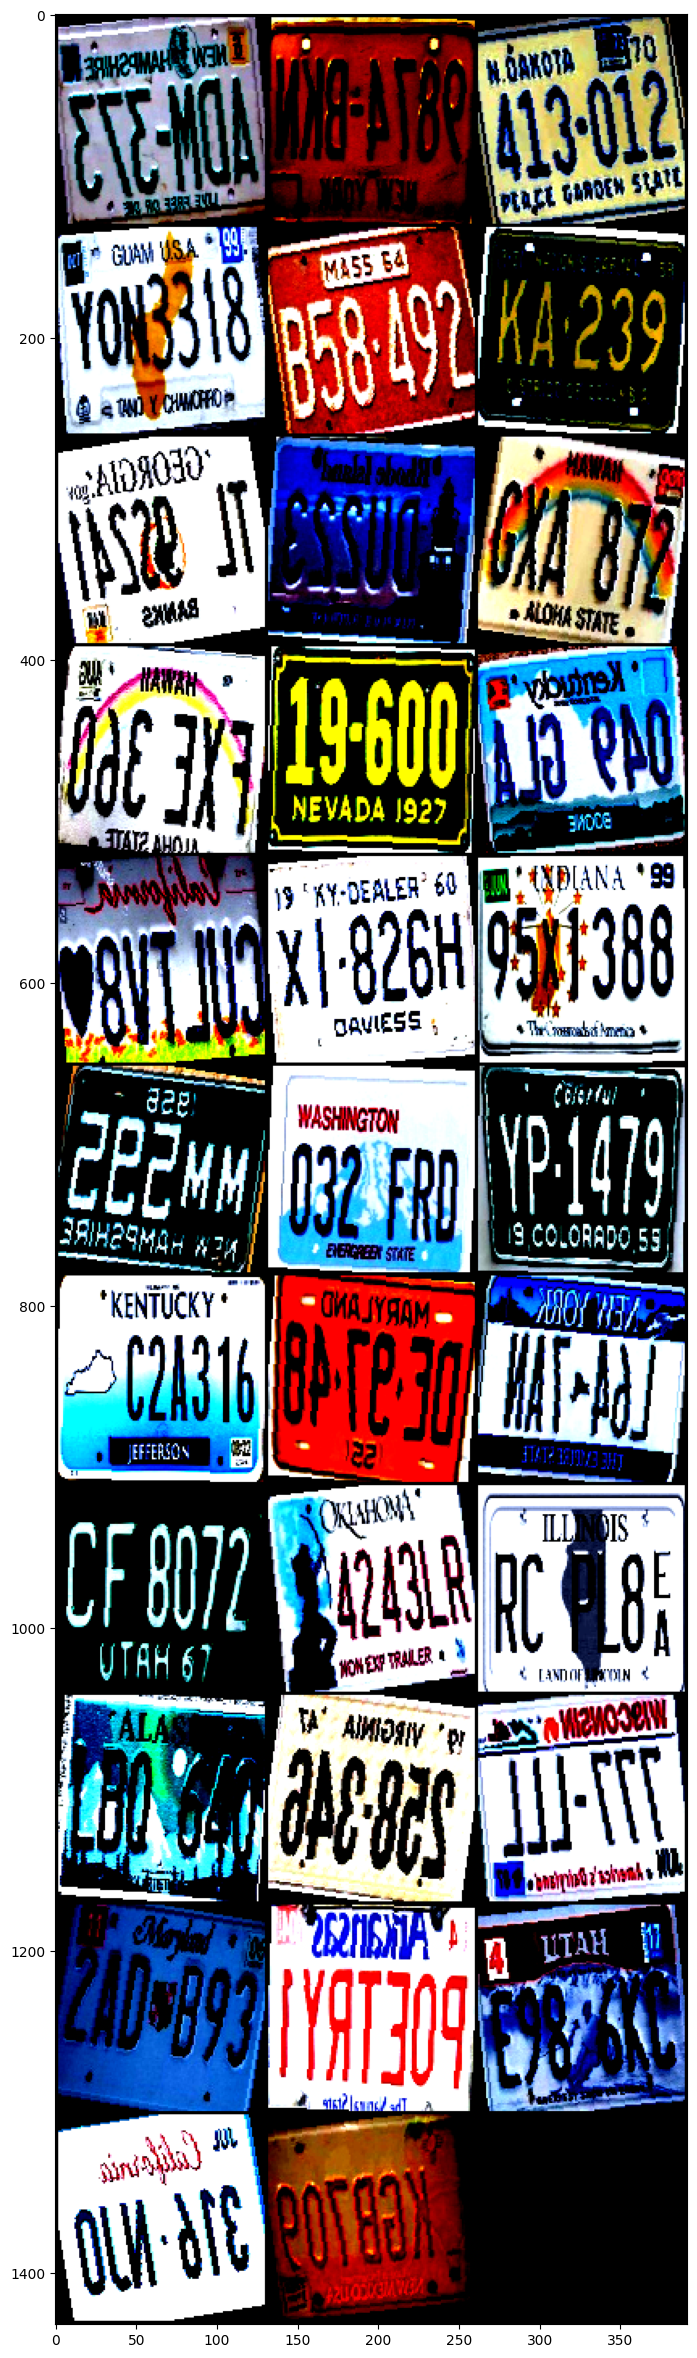

In [12]:
showTransformedImages(trainData)

In [13]:
# Train and Test data loader to load the images for training and testing phases

trainLoader = torch.utils.data.DataLoader(dataset = trainData, batch_size = 32, shuffle = True)
testLoader = torch.utils.data.DataLoader(dataset = testData, batch_size = 32, shuffle = False)

In [14]:
# Function to set the device to GPU if there is a supported and available GPU on the Machine 

def setDevice():
    return torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [15]:
# Function to train the neural network by taking model and serveral other parameters as inputs

def trainNeuralNetwork(model, trainLoader, testLoader, criterion, optimizer, nEpochs):
    epochLosses = []
    epochTrainAccuracies = []
    epochTestAccuracies = []
    yTrain, yPredictedTrain = [], []
    
    for epoch in range(nEpochs):
        print('\nEpoch number %d' % (epoch + 1))
        model.train()
        runningLoss = 0.0
        runningCorrect = 0.0
        total = 0
        
        for data in trainLoader:
            images, labels = data
            images = images.to(setDevice())
            labels = labels.to(setDevice())
            total += labels.size(0)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            yTrain.extend(labels.cpu().numpy().tolist())
            yPredictedTrain.extend(predicted.cpu().numpy().tolist())
            
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            runningLoss += loss.item()
            runningCorrect += (labels == predicted).sum().item()
            
        epochLoss = runningLoss/len(trainLoader)
        epochAcc = 100.00 * runningCorrect/total
        epochLosses.append(epochLoss)
        epochTrainAccuracies.append(epochAcc)
        
        print(" - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f" % (runningCorrect, total, epochAcc, epochLoss))
        epochTestAcc, yTest, yPredictedTest = evaluateModelOnTestSet(model, testLoader)
        epochTestAccuracies.append(epochTestAcc)
        
        print("Finished an Epoch")
    return epochLosses, epochTrainAccuracies, epochTestAccuracies, yTrain, yPredictedTrain, yTest, yPredictedTest, model

In [16]:
# Function for evaluating the selected model on the test data set

def evaluateModelOnTestSet(model, testLoader):
    model.eval()
    predictedCorrectlyOnEpoch = 0
    total = 0
    yTest, yPredictedTest = [], []
    
    with torch.no_grad():
        for data in testLoader:
            images, labels = data
            images = images.to(setDevice())
            labels = labels.to(setDevice())
            total += labels.size(0)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            yTest.extend(labels.cpu().numpy().tolist())
            yPredictedTest.extend(predicted.cpu().numpy().tolist())
            predictedCorrectlyOnEpoch += (predicted == labels).sum().item()
            
    epochAcc = 100.00 * predictedCorrectlyOnEpoch/total
        
    print(" - Testing dataset. Got %d out of %d images correctly (%.3f%%)" % (predictedCorrectlyOnEpoch, total, epochAcc))
    return epochAcc, yTest, yPredictedTest

In [17]:
# Function to visualise the Epoch losses, Training and testing accuracies

def showPlots(val, epochLosses, epochTrainAccuracies, epochTestAccuracies):        
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15, 8))
    ax1.plot(epochLosses, marker="o", markersize= 3)
    ax1.set_title("AlexNet Epoch Loss" if val == 1 else "ResNet Epoch Loss")
    ax2.plot(epochTrainAccuracies, marker="o", markersize= 3)
    ax2.set_title("AlexNet Epoch Training Accuracy" if val == 1 else "ResNet Epoch Training Accuracy")
    ax3.plot(epochTestAccuracies, marker="o", markersize= 3)
    ax3.set_title("AlexNet Epoch Testing Accuracy" if val == 1 else "ResNet Epoch Testing Accuracy")
    plt.xlabel("Epochs")
    plt.show()

In [18]:
# Function to calculate the various things like accuracy, precision, score, etc of the model

def calculateMetrics(model, yTrain, yPredictedTrain, yTest, yPredictedTest):
    print('****************************ResNet18*******************************' if model == 0 else '*******************************AlexNet*****************************************')
    t = PrettyTable(['Metric | Phase', 'Train', 'Test'])
    
    trainAccuracy = accuracy_score(yTrain, yPredictedTrain)
    #trainPrecision = precision_score(yTrain, yPredictedTrain)
    #trainRecall = recall_score(yTrain, yPredictedTrain)
    #trainF1Score = f1_score(yTrain, yPredictedTrain)
    trainR2Score = r2_score(yTrain, yPredictedTrain)
    trainMeanSquaredError = mean_squared_error(yTrain, yPredictedTrain)
    trainRootMeanSquaredError = sqrt(trainMeanSquaredError)
    
    testAccuracy = accuracy_score(yTest, yPredictedTest)
    #testPrecision = precision_score(yTest, yPredictedTest)
    #testRecall = recall_score(yTest, yPredictedTest)
    #testF1Score = f1_score(yTest, yPredictedTest)
    testR2Score = r2_score(yTest, yPredictedTest)
    testMeanSquaredError = mean_squared_error(yTest, yPredictedTest)
    testRootMeanSquaredError = sqrt(testMeanSquaredError)
    
    t.add_row(['Accuracy', trainAccuracy, testAccuracy])
    #t.add_row(['Precision', trainPrecision, testPrecision])
    #t.add_row(['Recall', trainRecall, testRecall])
    #t.add_row(['F1-Score', trainF1Score, testF1Score])
    t.add_row(['R2-Score', trainR2Score, testR2Score])
    t.add_row(['Mean Squared Error', trainMeanSquaredError, testMeanSquaredError])
    t.add_row(['Root Mean Squared Error', trainRootMeanSquaredError, testRootMeanSquaredError])
    
    print(t)
    
    #print("Train Accuracy: {}".format(trainAccuracy))
    #print("Train Precision: {}".format(trainPrecision))
    #print("Train Recall: {}".format(trainRecall))
    #print("Train F1-Score: {}".format(trainF1Score))
    #print("Train R2-Score: {}".format(trainR2Score))
    #print("Train Mean Squared Error: {}".format(trainMeanSquaredError))
    #print("Train Root Mean Squared Error: {}".format(trainRootMeanSquaredError))
    
    #print("Test Accuracy: {}".format(testAccuracy))
    #print("Test Precision: {}".format(testPrecision))
    #print("Test Recall: {}".format(testRecall))
    #print("Test F1-Score: {}".format(testF1Score))
    #print("Test R2-Score: {}".format(testR2Score))
    #print("Test Mean Squared Error: {}".format(testMeanSquaredError))
    #print("Test Root Mean Squared Error: {}".format(testRootMeanSquaredError))

In [19]:
# Function to plot the heatmap for the choosen data

df = pd.read_csv('../archive-license_plates/new_plates/plates.csv')
labelNames = df['labels']
labels = labelNames.drop_duplicates()

def plotGraph(yTrain, yPredictedTrain, yTest, yPredictedTest):
    confusionMatrixTrain = confusion_matrix(yTrain, yPredictedTrain)
    confusionMatrixTest = confusion_matrix(yTest, yPredictedTest)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(50, 50))
    sns.heatmap(confusionMatrixTrain, annot=True, fmt='d', ax=ax1, xticklabels=labels, yticklabels=labels)
    ax1.set_title('Train Data')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    sns.heatmap(confusionMatrixTest, annot=True, fmt='d', ax=ax2, xticklabels=labels, yticklabels=labels)
    ax2.set_title('Test Data')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    plt.show()

In [20]:
# Using the resnet model for image classification

resNet18Model = models.resnet18(pretrained = False)
numFtrs = resNet18Model.fc.in_features
numberOfClasses = 56
resNet18Model.fc = NN.Linear(numFtrs, numberOfClasses)
resNet18Model = resNet18Model.to(setDevice())
lossFunction = NN.CrossEntropyLoss()

optimizer = optim.SGD(resNet18Model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 0.003)

Time Before => 2023-11-21 15:56:31.042333

Epoch number 1
 - Training dataset. Got 892 out of 8161 images correctly (10.930%). Epoch loss: 3.791
 - Testing dataset. Got 46 out of 280 images correctly (16.429%)
Finished an Epoch

Epoch number 2
 - Training dataset. Got 2551 out of 8161 images correctly (31.258%). Epoch loss: 2.877
 - Testing dataset. Got 93 out of 280 images correctly (33.214%)
Finished an Epoch

Epoch number 3
 - Training dataset. Got 3506 out of 8161 images correctly (42.960%). Epoch loss: 2.327
 - Testing dataset. Got 119 out of 280 images correctly (42.500%)
Finished an Epoch

Epoch number 4
 - Training dataset. Got 4194 out of 8161 images correctly (51.391%). Epoch loss: 1.954
 - Testing dataset. Got 122 out of 280 images correctly (43.571%)
Finished an Epoch

Epoch number 5
 - Training dataset. Got 4762 out of 8161 images correctly (58.351%). Epoch loss: 1.635
 - Testing dataset. Got 142 out of 280 images correctly (50.714%)
Finished an Epoch

Epoch number 6
 - Tr

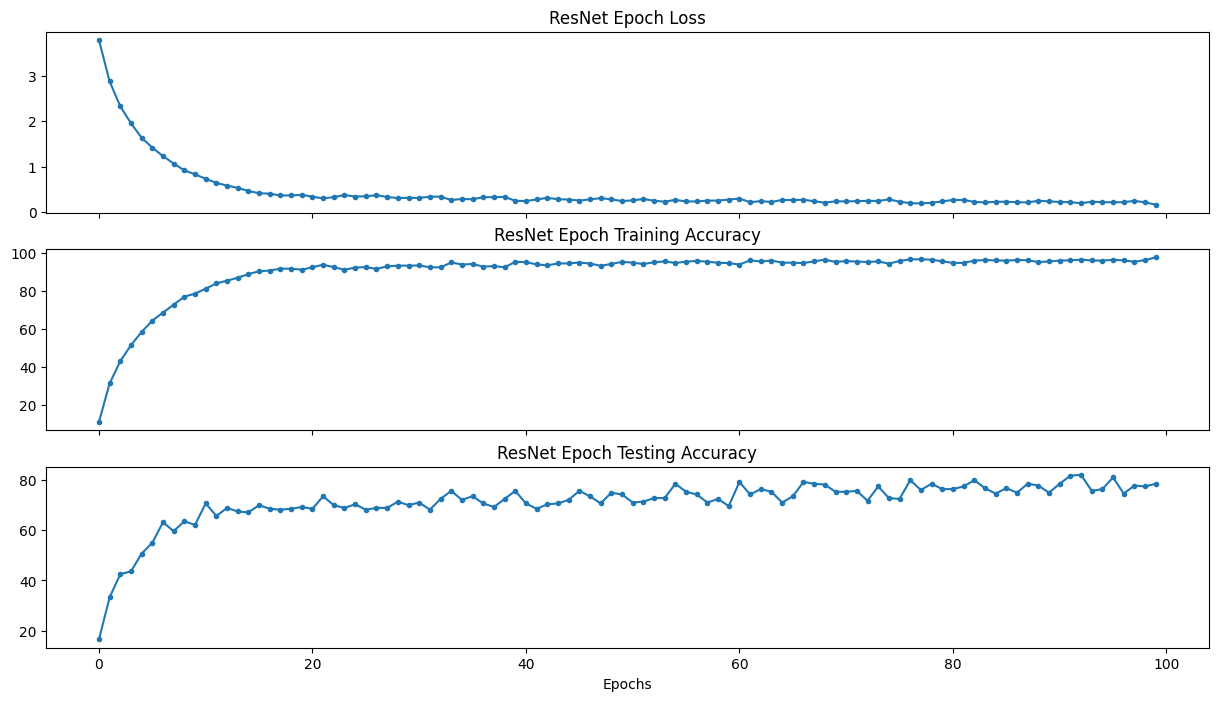

****************************ResNet18*******************************
+-------------------------+--------------------+--------------------+
|      Metric | Phase     |       Train        |        Test        |
+-------------------------+--------------------+--------------------+
|         Accuracy        | 0.9015500551403014 | 0.7857142857142857 |
|         R2-Score        | 0.8096799590911359 | 0.4324265208475735 |
|    Mean Squared Error   |  49.714538659478   | 148.27857142857144 |
| Root Mean Squared Error |   7.050853753942   | 12.17696889330721  |
+-------------------------+--------------------+--------------------+


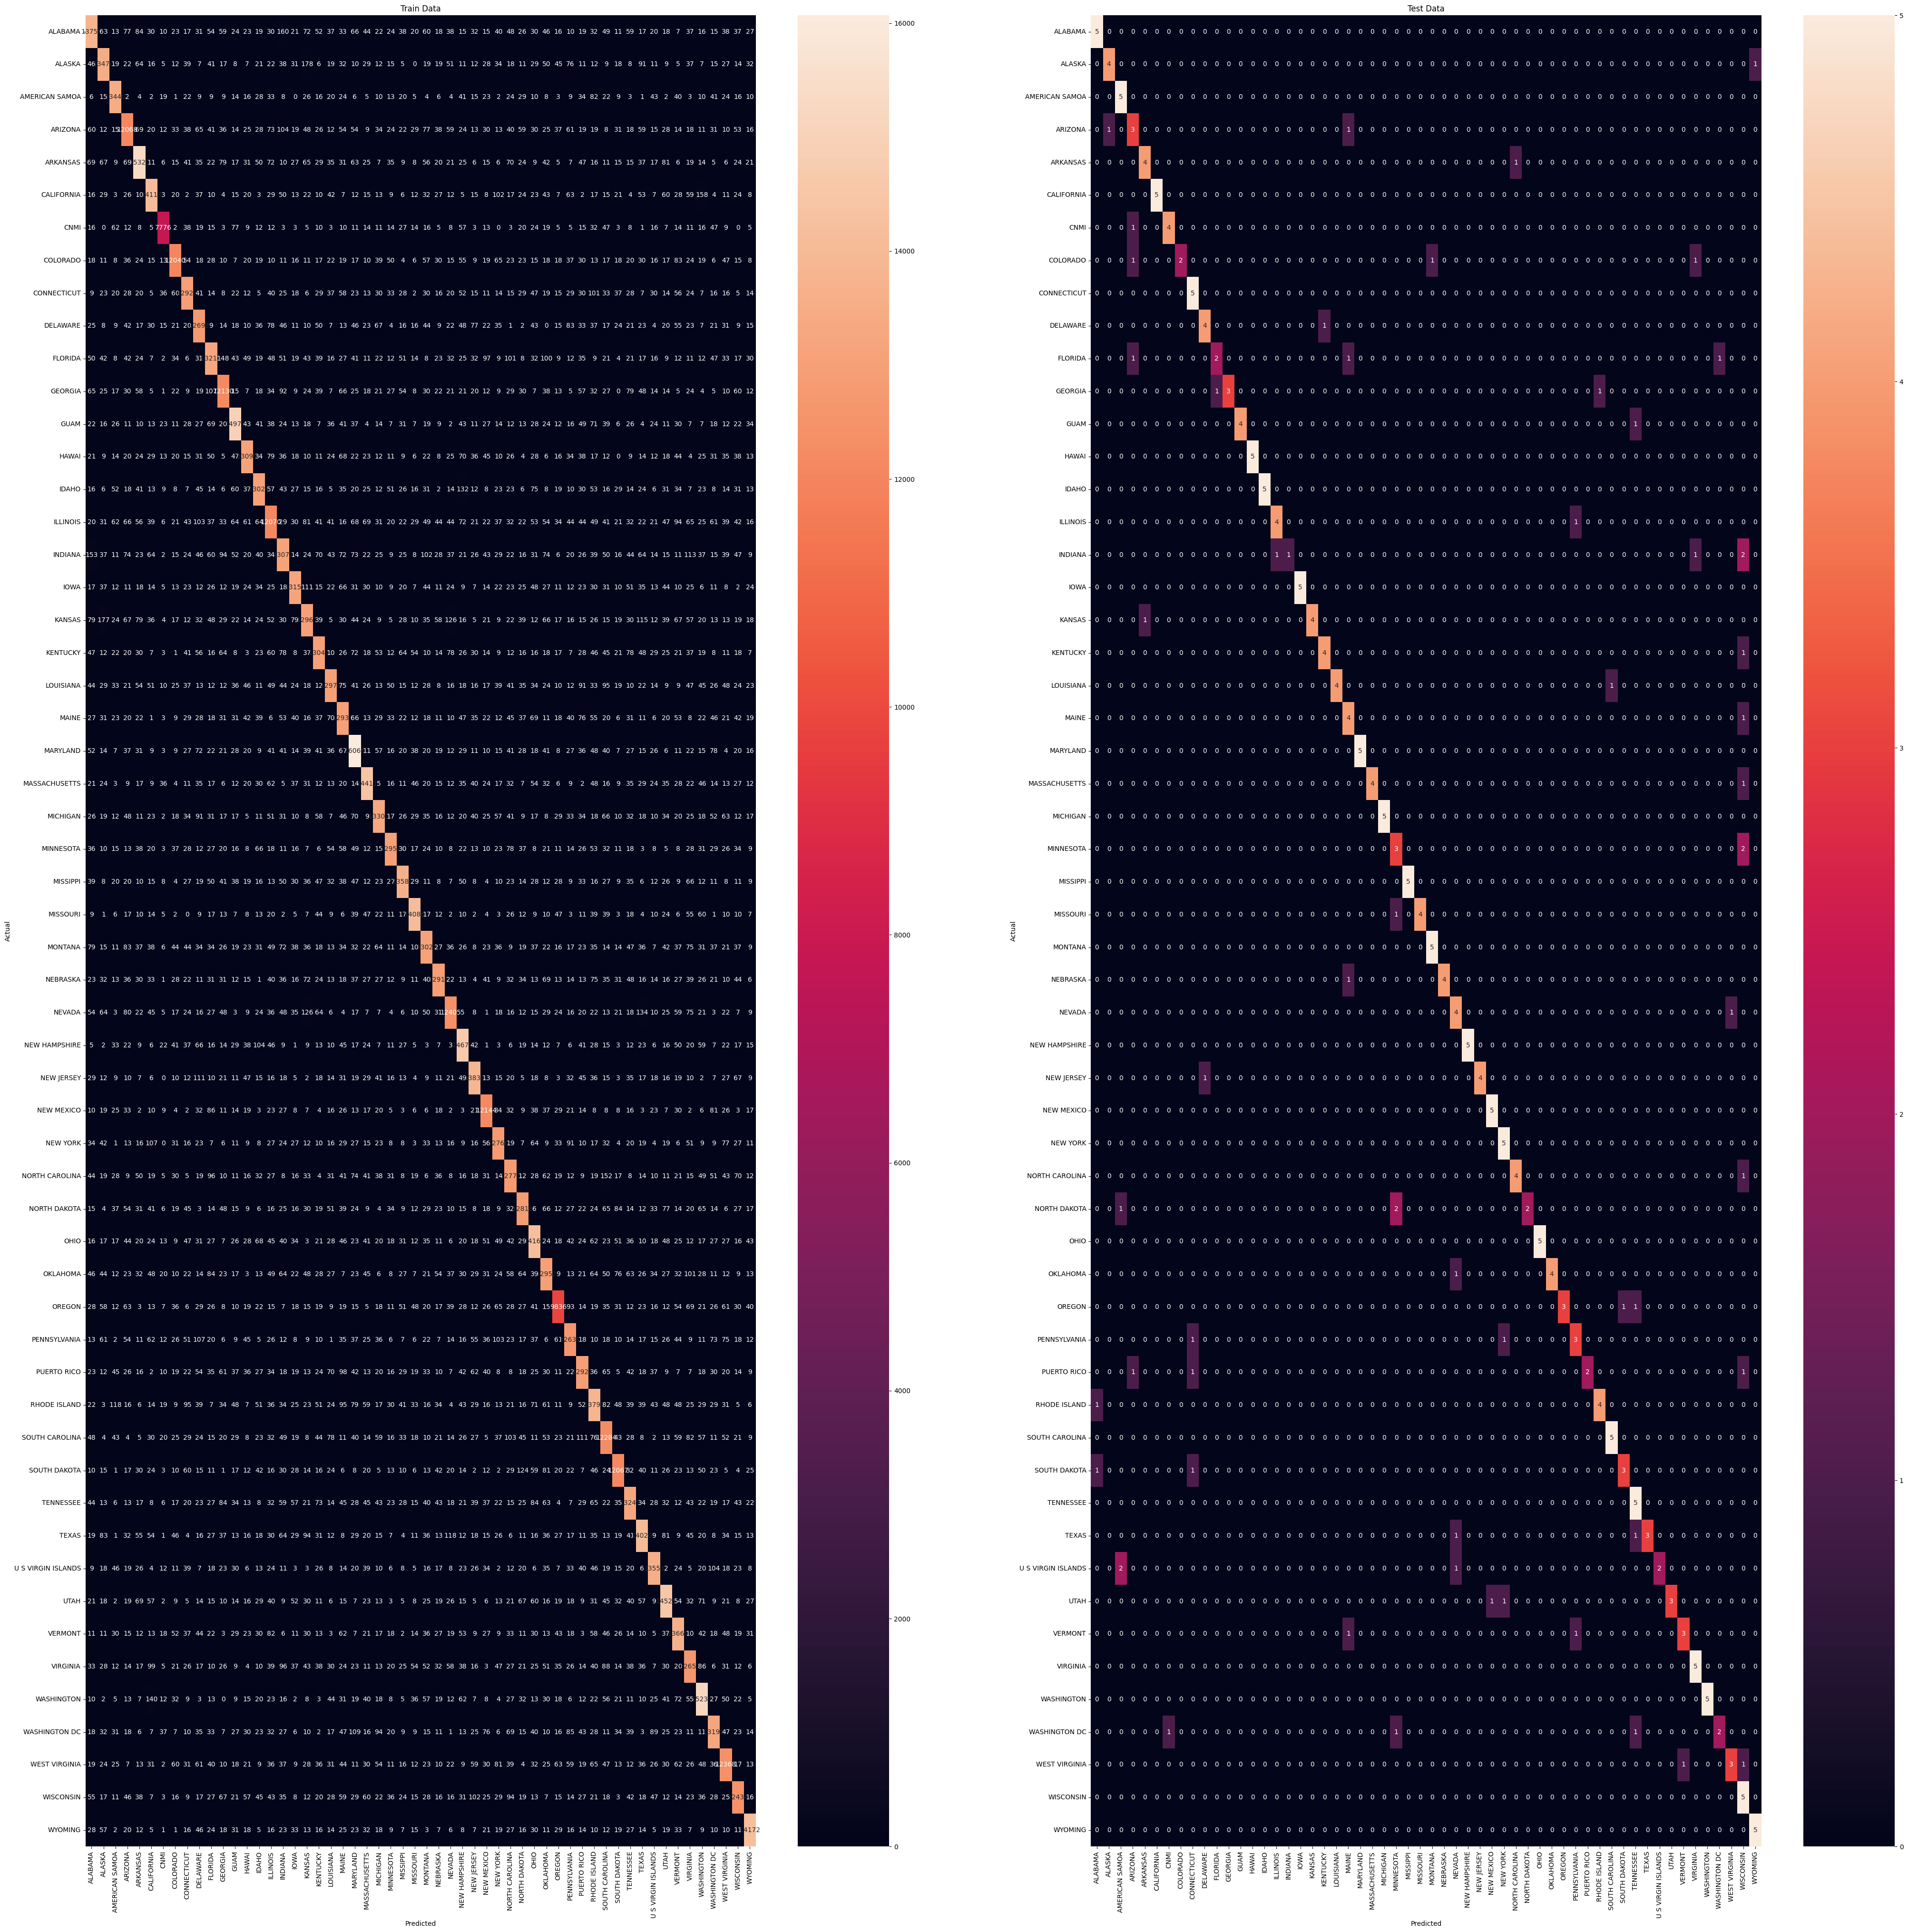

Time After => 2023-11-21 16:39:06.365122


<IPython.core.display.Javascript object>

In [21]:
%%notify -m "ResNet Execution Done !"

global resNetParams
resNetParams = []
print('Time Before =>',datetime.datetime.now())
epochLosses, epochTrainAccuracies, epochTestAccuracies, yTrain, yPredictedTrain, yTest, yPredictedTest, NeuralNetworkModel  = trainNeuralNetwork(resNet18Model, trainLoader, testLoader, lossFunction, optimizer, 100)
print('\nNeural Network Model is ',NeuralNetworkModel)
showPlots(0, epochLosses, epochTrainAccuracies, epochTestAccuracies)
calculateMetrics(0, yTrain, yPredictedTrain, yTest, yPredictedTest)
plotGraph(yTrain, yPredictedTrain, yTest, yPredictedTest)
resNetParams.append(epochLosses)
resNetParams.append(epochTrainAccuracies)
resNetParams.append(epochTestAccuracies)
print('Time After =>',datetime.datetime.now()) 

In [36]:
# Using the alexnet model for image classification

alexNetModel = models.alexnet(pretrained = False)
numFtrs = 512
numberOfClasses = 56
alexNetModel.fc = NN.Linear(numFtrs, numberOfClasses)
alexNetModel = alexNetModel.to(setDevice())
lossFunction = NN.CrossEntropyLoss()

optimizer = optim.SGD(alexNetModel.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 0.0001)

Time Before => 2023-11-21 17:01:43.589890

Epoch number 1
 - Training dataset. Got 138 out of 8161 images correctly (1.691%). Epoch loss: 5.491
 - Testing dataset. Got 5 out of 280 images correctly (1.786%)
Finished an Epoch

Epoch number 2
 - Training dataset. Got 161 out of 8161 images correctly (1.973%). Epoch loss: 4.185
 - Testing dataset. Got 5 out of 280 images correctly (1.786%)
Finished an Epoch

Epoch number 3
 - Training dataset. Got 149 out of 8161 images correctly (1.826%). Epoch loss: 4.139
 - Testing dataset. Got 5 out of 280 images correctly (1.786%)
Finished an Epoch

Epoch number 4
 - Training dataset. Got 140 out of 8161 images correctly (1.715%). Epoch loss: 4.128
 - Testing dataset. Got 5 out of 280 images correctly (1.786%)
Finished an Epoch

Epoch number 5
 - Training dataset. Got 135 out of 8161 images correctly (1.654%). Epoch loss: 4.097
 - Testing dataset. Got 5 out of 280 images correctly (1.786%)
Finished an Epoch

Epoch number 6
 - Training dataset. Got 13

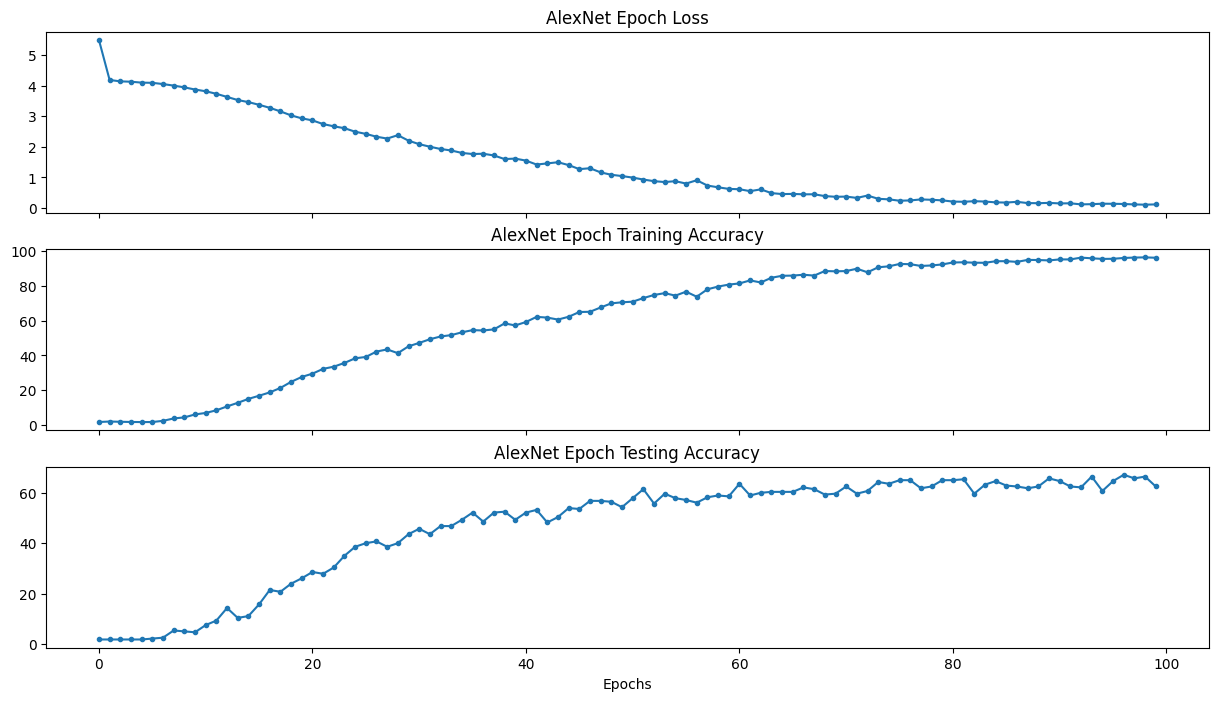

*******************************AlexNet*****************************************
+-------------------------+---------------------+---------------------+
|      Metric | Phase     |        Train        |         Test        |
+-------------------------+---------------------+---------------------+
|         Accuracy        |  0.6167785810562431 |        0.625        |
|         R2-Score        | -0.9015691380778059 | 0.36340396445659606 |
|    Mean Squared Error   |  496.7192733733611  |  166.31071428571428 |
| Root Mean Squared Error |  22.287199765187214 |  12.896151142325927 |
+-------------------------+---------------------+---------------------+


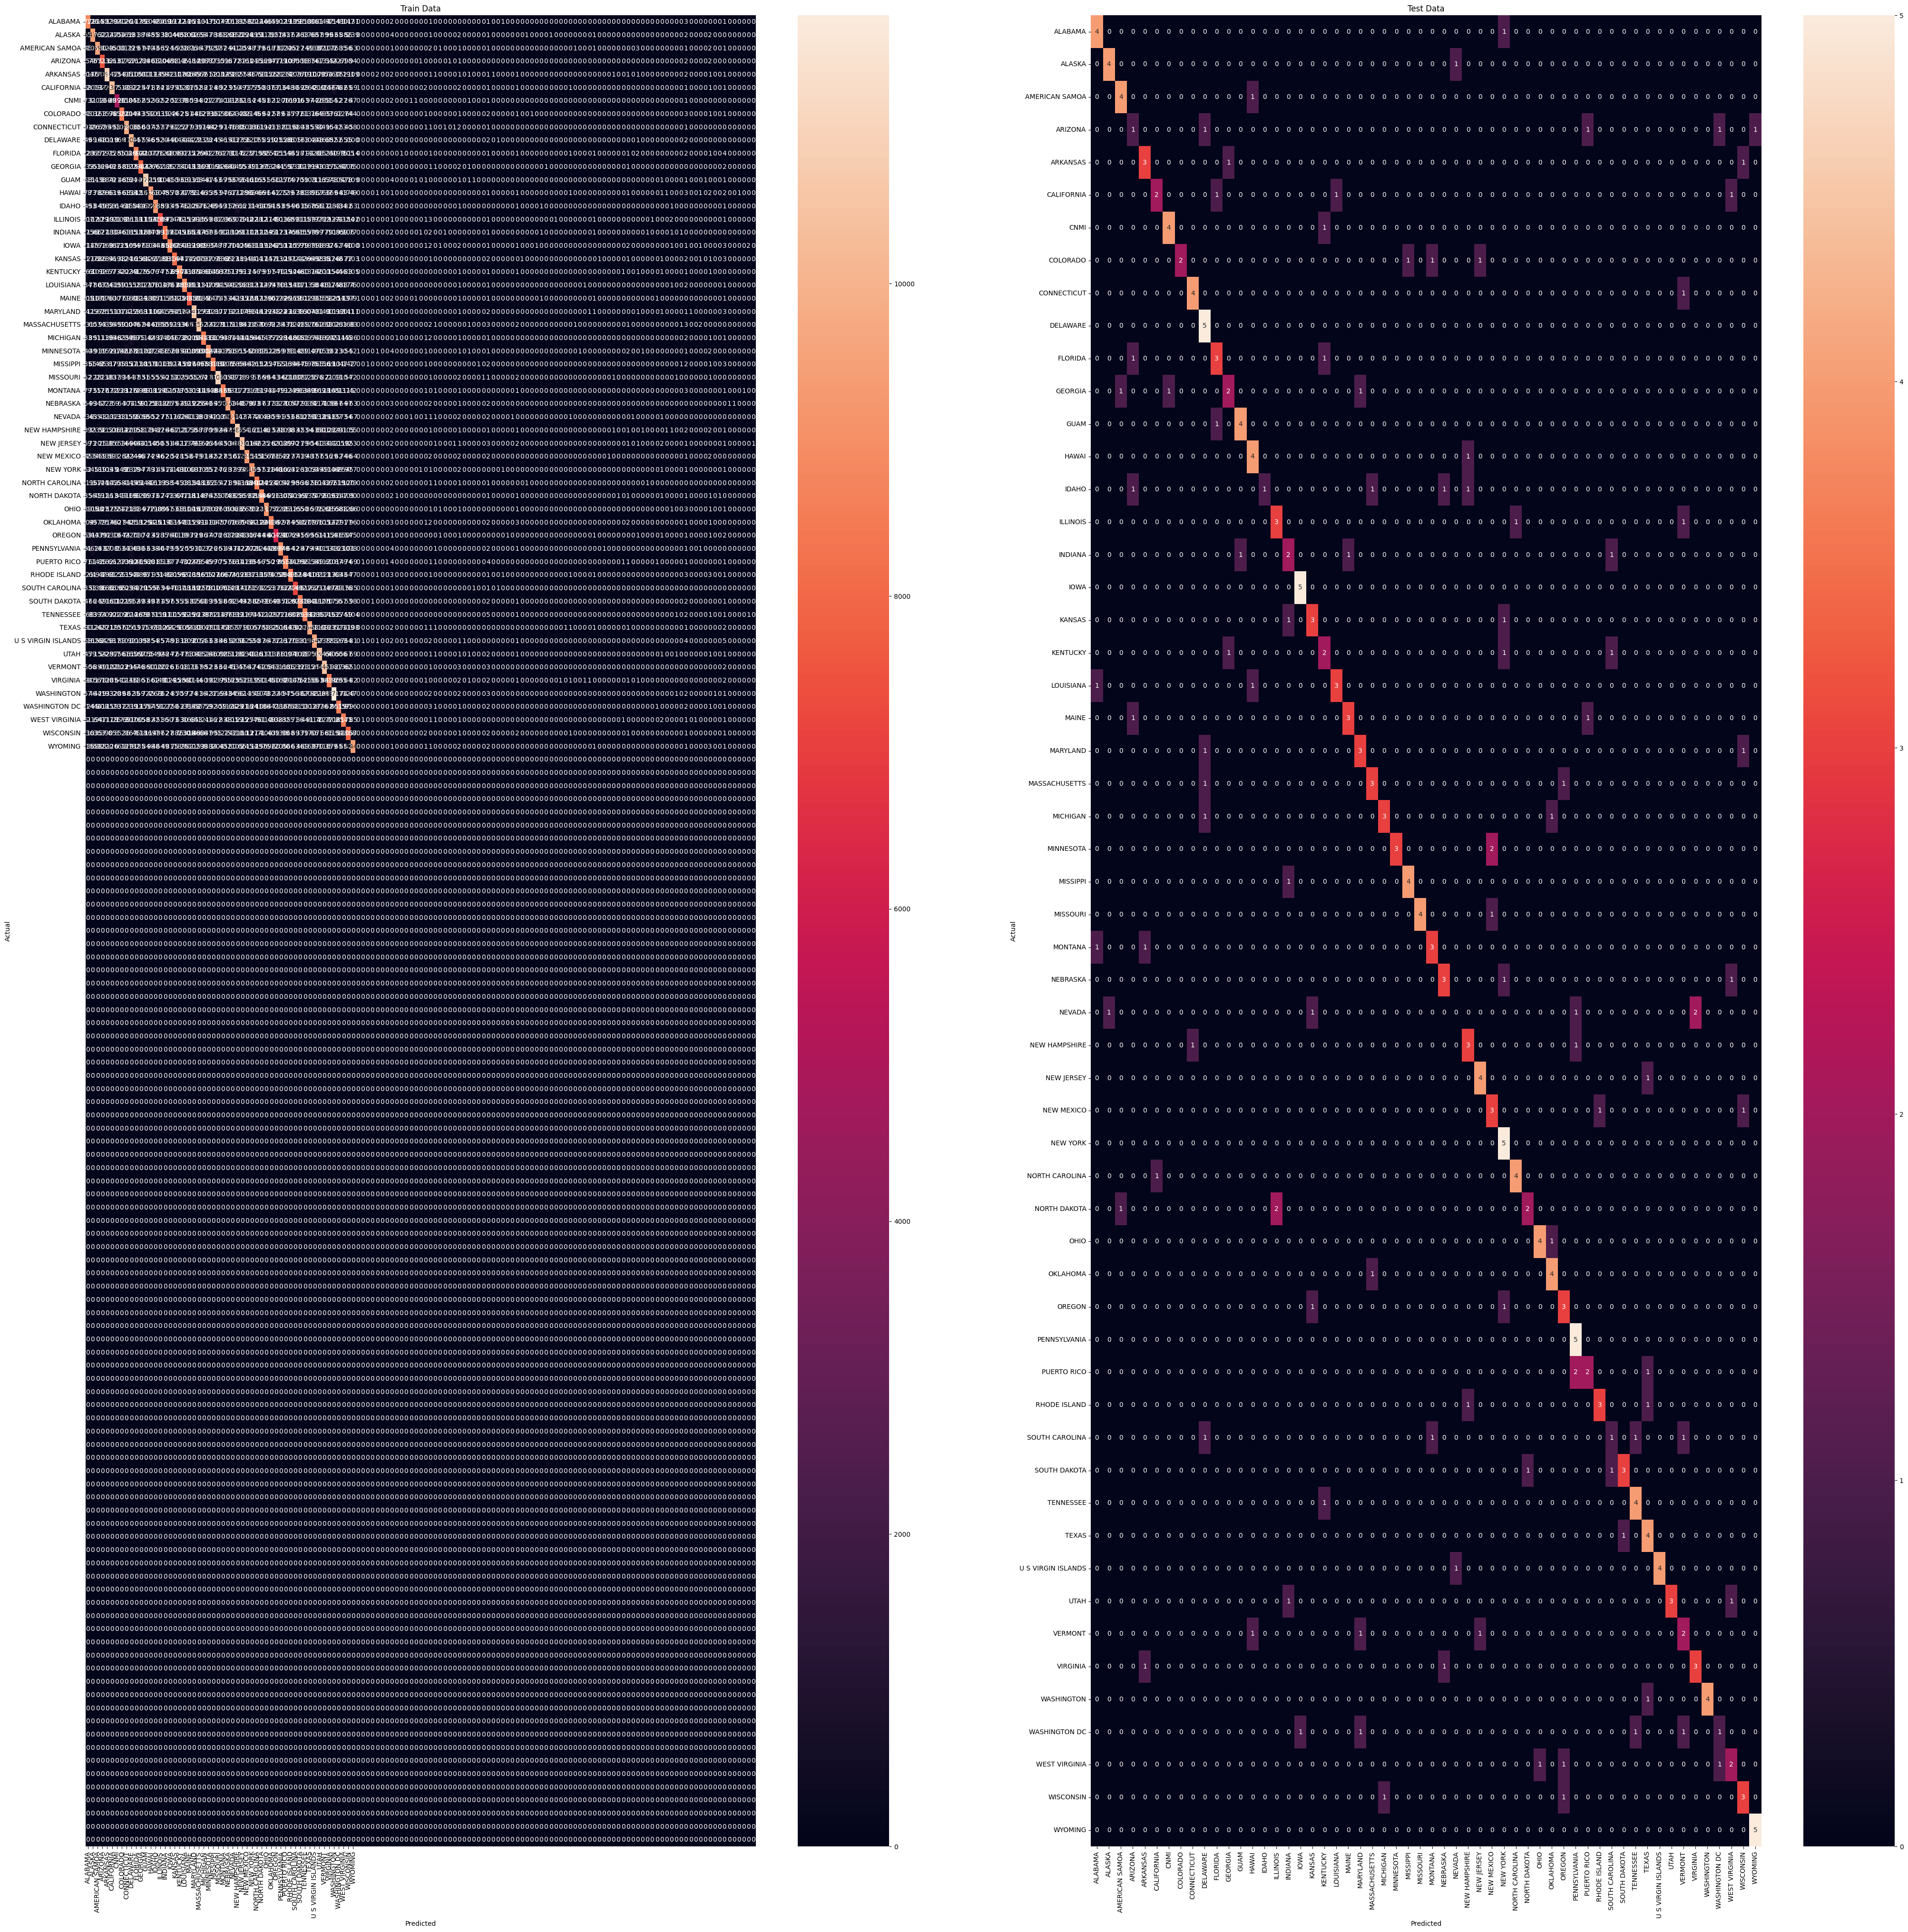

Time After => 2023-11-21 17:34:21.049000


<IPython.core.display.Javascript object>

In [37]:
%%notify -m "AlexNet Execution Done !"

global alexNetParams
alexNetParams = []
print('Time Before =>',datetime.datetime.now())
epochLosses, epochTrainAccuracies, epochTestAccuracies, yTrain, yPredictedTrain, yTest, yPredictedTest, NeuralNetworkModel = trainNeuralNetwork(alexNetModel, trainLoader, testLoader, lossFunction, optimizer, 100)
print('\nNeural Network Model is ',NeuralNetworkModel)
showPlots(1, epochLosses, epochTrainAccuracies, epochTestAccuracies)
calculateMetrics(1, yTrain, yPredictedTrain, yTest, yPredictedTest)
plotGraph(yTrain, yPredictedTrain, yTest, yPredictedTest)
alexNetParams.append(epochLosses)
alexNetParams.append(epochTrainAccuracies)
alexNetParams.append(epochTestAccuracies)
print('Time After =>',datetime.datetime.now())

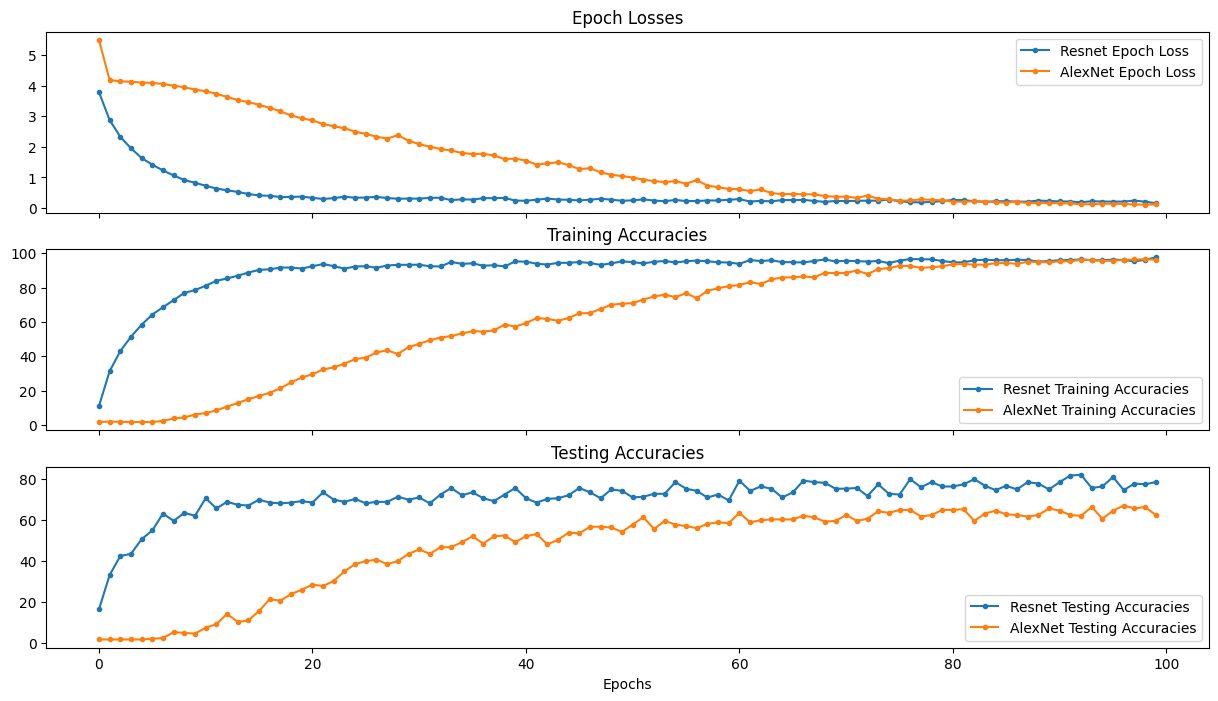

In [38]:
# To plot all the graphs for both models on a single graph to make comparison easy

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15, 8))
ax1.plot(resNetParams[0], marker="o", markersize= 3, label = "Resnet Epoch Loss")
ax1.plot(alexNetParams[0], marker="o", markersize= 3, label = "AlexNet Epoch Loss")
ax1.set_title("Epoch Losses")
ax1.legend()
ax2.plot(resNetParams[1], marker="o", markersize= 3, label = "Resnet Training Accuracies")
ax2.plot(alexNetParams[1], marker="o", markersize= 3, label = "AlexNet Training Accuracies")
ax2.set_title("Training Accuracies")
ax2.legend()
ax3.plot(resNetParams[2], marker="o", markersize= 3, label = "Resnet Testing Accuracies")
ax3.plot(alexNetParams[2], marker="o", markersize= 3, label = "AlexNet Testing Accuracies")
ax3.set_title("Testing Accuracies")
ax3.legend()
plt.xlabel("Epochs")
plt.show()